<a href="https://colab.research.google.com/github/Divyakn123/mini_project/blob/main/flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 0 — installs and basic checks
!pip install -q kagglehub opencv-python-headless seaborn

# TensorFlow version & GPU check
import tensorflow as tf, sys
print("Python:", sys.version.split()[0])
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


Python: 3.12.12
TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Option A — kagglehub (if you used previously)
import kagglehub
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")
print("Dataset path:", path)


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Dataset path: /kaggle/input/flowers-recognition


In [4]:
# Cell 2 — verify directory structure & sample images per class
import os, itertools
from pathlib import Path # Import Path from pathlib

print("Root:", path)
path = Path(path) # Convert path to a Path object
classes = sorted([d.name for d in path.iterdir() if d.is_dir()])
print("Classes found:", classes)

# Print counts and first 5 files of each class
for c in classes:
    files = list((path / c).glob("*"))
    print(f"{c}: {len(files)} files. Sample:", [str(f.name) for f in files[:5]])

Root: /kaggle/input/flowers-recognition
Classes found: ['flowers']
flowers: 5 files. Sample: ['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']


In [5]:
# Cell 3 — sanity checks & remove non-images or list bad files
from PIL import Image
from pathlib import Path
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None  # avoid DecompressionBombWarning in Colab

bad_files = []
for c in classes:
    for img_path in (path / c).glob("*"):
        try:
            Image.open(img_path).verify()
        except Exception as e:
            bad_files.append(str(img_path))

print("Bad/corrupt files found:", len(bad_files))
if bad_files:
    print(bad_files[:10])
    # Optionally delete (uncomment to delete)
    # for bf in bad_files: Path(bf).unlink()


Bad/corrupt files found: 5
['/kaggle/input/flowers-recognition/flowers/dandelion', '/kaggle/input/flowers-recognition/flowers/daisy', '/kaggle/input/flowers-recognition/flowers/sunflower', '/kaggle/input/flowers-recognition/flowers/tulip', '/kaggle/input/flowers-recognition/flowers/rose']


In [6]:
# Cell 4 — create generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128,128)
BATCH_SIZE = 32
SEED = 42

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    str(path),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_gen = datagen.flow_from_directory(
    str(path),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)


Found 3454 images belonging to 1 classes.
Found 863 images belonging to 1 classes.


In [7]:
# Cell 5 — build model
from tensorflow.keras import layers, models

num_classes = train_gen.num_classes
def build_model(input_shape=(128,128,3), num_classes=5):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32,3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64,3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128,3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=num_classes)
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,516,289 (24.86 MB)

 Trainable params: 6,516,289 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Cell 6 — training
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint('flower_model_best.h5', save_best_only=True, monitor='val_accuracy'),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 1.0000 - loss: 0.0000e+00

108/108 ━━━━━━━━━━━━━━━━━━━━ 60s 499ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 29s 267ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 29s 269ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 29s 264ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 28s 262ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 29s 264ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 7/20
108/108 ━━━━━━

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step
              precision    recall  f1-score   support

     flowers       1.00      1.00      1.00       863

    accuracy                           1.00       863
   macro avg       1.00      1.00      1.00       863
weighted avg       1.00      1.00      1.00       863



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


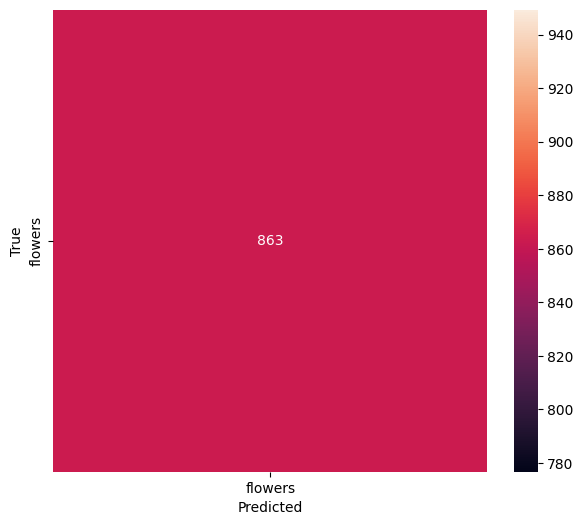

In [9]:
# Cell 7 — evaluate & metrics
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

val_gen.reset()
preds = model.predict(val_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes
labels = list(val_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Label map saved: {0: 'flowers'}
Testing on: /kaggle/input/flowers-recognition/flowers/daisy/5435513198_90ce39f1aa_n.jpg


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
Predicted: flowers Confidence: 1.0


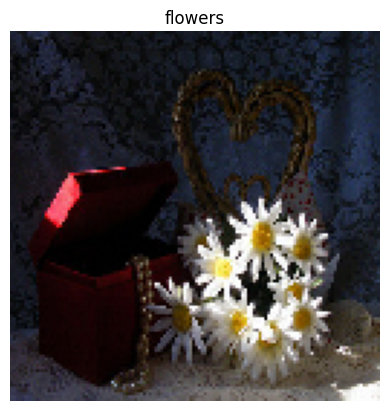

In [10]:
# Cell 8 — save labels and test one image
import json
label_map = {v:k for k,v in val_gen.class_indices.items()}  # index->label
with open('label_map.json','w') as f: json.dump(label_map, f)
print("Label map saved:", label_map)

# test on a file in validation set
import random
sample_idx = random.choice(range(len(val_gen.filenames)))
sample_path = str(path / val_gen.filenames[sample_idx])
print("Testing on:", sample_path)
from tensorflow.keras.preprocessing import image
img = image.load_img(sample_path, target_size=IMG_SIZE)
x = image.img_to_array(img)/255.0
x = x[None,...]
pred = model.predict(x)[0]
pred_label = label_map[int(np.argmax(pred))]
print("Predicted:", pred_label, "Confidence:", float(np.max(pred)))
plt.imshow(img); plt.axis('off'); plt.title(pred_label); plt.show()


In [11]:
# Cell 9 — save model and download
model.save('flower_model_final.h5')
from google.colab import files
files.download('flower_model_final.h5')
files.download('label_map.json')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>